# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [3]:
%run hw_framework.ipynb

Wall time: 155 ms
Wall time: 9 ms


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [4]:
def SGD(params, gradients, lr=1e-3):
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [5]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

In [ ]:
#На этих крошечных примерах я проверил работоспособность моих слоев. В сравнении с pytorch даже не хуже!

# Линейная регрессия

In [3]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w)  + np.random.randn(n, 1)/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w), 2)))

best_possible_mse: 0.04098471863957657


### Модель

In [22]:
model = Sequential(
    Linear(10, 5),
    LeakyReLU(),
    Linear(5,4),
    LeakyReLU(),
    Linear(4,1)
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [8]:
epochs = 20
batch_size = 10
learning_rate = 1e-2

11.25192744874055
10.012255147536717
24.098560219812736
10.090324336181855
12.966688262202442
13.251194631114307
20.67196359052229
4.484176533523352
11.455067154955348
15.292156734677102
24.999524283443133
21.015636850946642
34.051768336959114
15.775446301033071
8.320681680899149
6.91483097589383
13.544396716239826
12.04625189958917
14.242952490816373
24.33312687801823
12.245022241251236
8.537728283196417
13.052424039032786
16.520863608350066
21.092852445758933
16.5750190332737
29.16468652894789
21.447193808943915
15.799895193948112
9.945608000209145
17.30087499446242
17.10602671457869
12.118505975652576
13.046136850989097
13.664124632174827
26.387834604500334
15.219509528091129
35.188895515422246
10.700689929101902
24.91512226609575
6.47235999058627
11.132229565305291
15.210559382343169
4.334926397604823
11.451266554790065
21.80829160392266
19.68372677997395
8.699014756992899
13.527842229179573
9.254856284264275
7.280298271147323
11.616530785067301
3.702673958560477
8.848068289222738


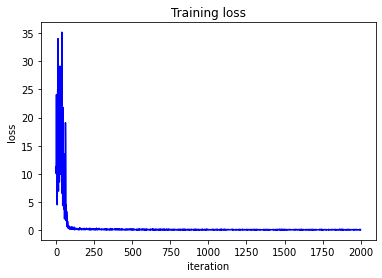

In [23]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(), model.grad_parameters(), learning_rate)
        
        
        print(loss)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

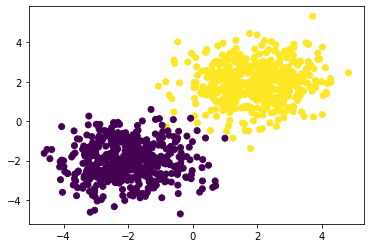

In [24]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [41]:
model = Sequential(
    Linear(2, 5),
    BatchNorm(5),
    ReLU(),
    Linear(5,2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [40]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

26.99300973337584
26.070103375133854
25.139528232148244
24.746856534291695
25.32679436889496
24.916904075545084
22.92452555940984
22.6736244929263
23.100004053997843
24.294656378342445
23.569606682323986
21.845285847959328
20.334485155602334
21.005379901017328
22.032619264224827
19.783003944841937
20.87804254318759
17.87664351732331
16.81979200063936
24.424233610578867
17.72253175959286
20.501458953881063
20.779099583384767
21.307623866220347
18.296462938173338
16.2977393580461
24.49152497469362
17.21431599792826
18.388452151228414
20.273506493140466
17.27289344139412
18.027801899862542
16.57570679742334
16.712630139826942
15.441686640031996
15.782200599757694
15.187570895608012
16.209796025767297
15.508519564049596
15.720549121840076
15.569349781964997
14.157777772647652
15.709928066376776
15.841187706699552
14.624753848300486
15.386300833557957
16.030845720889467
12.815861149194259
12.772722738602916
12.86145121837001
13.405929257396357
15.5182200855214
11.191084993357535
11.07162247

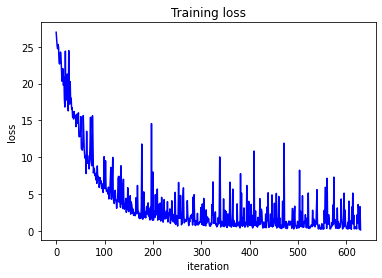

In [42]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        print(loss)
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

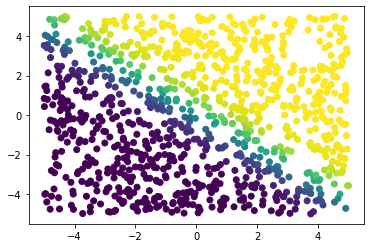

In [43]:
#Из-за того, что я в лосе (кроссэнтропии) заложил уменьшение вероятности неправильных классов для конкретного объекта, 
#линия разделения классов более четкая
n = 1000
X_test = np.random.uniform(-5, 5, (n, 2))
Y_test = model.forward(X_test)

plt.scatter(X_test[:,0], X_test[:,1], c=Y_test[:,0])
plt.show()


Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [ ]:
#У меня не получается скачать mnist через sklearn, поэтому я воспользуюсь pytorch

In [ ]:
import os
from sklearn.datasets import fetch_mldata
# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

In [145]:
import torch
from torchvision import datasets, transforms

In [ ]:
#Здесь качаем картинки для train
train_x = np.ones((1,28,28))
train_y = np.array([])
dataset = datasets.MNIST('mnist', train=True, download=True,
        transform=transforms.ToTensor())

for x,y in dataset:
    train_x = np.vstack((train_x,x.numpy()))
    train_y = np.append(train_y,y)

train_x = np.delete(train_x, 0, axis=0)
train_x = train_x.reshape(60000, 28**2)

In [125]:
#А здесь качаем картинки для validation
val_x = np.ones((1,28,28))
val_y = np.array([])
dataset = datasets.MNIST('mnist', train=False, download=True,
        transform=transforms.ToTensor())
b = 0
for x,y in dataset:
    val_x = np.vstack((val_x,x.numpy()))
    val_y = np.append(val_y,y)

val_x = np.delete(val_x, 0, axis=0)
val_x = val_x.reshape(10000, 28**2)

In [ ]:
import pickle as p
#Сохраню на всякий случай

In [144]:
with open('train_x.pkl', 'wb') as file:
    p.dump(train_x, file)
with open('train_y.pkl', 'wb') as file:
    p.dump(train_y, file)

In [ ]:
with open('val_x.pkl', 'wb') as file:
    p.dump(val_x, file)
with open('val_y.pkl', 'wb') as file:
    p.dump(val_y, file)

In [221]:
#От сюда можно забрать сохраненные файлы
with open('train_x.pkl', 'rb') as file:
    train_x = p.load(file)
with open('train_y.pkl', 'rb') as file:
    train_y = p.load(file)

In [222]:
with open('val_x.pkl', 'rb') as file:
    val_x = p.load(file)
with open('val_y.pkl', 'rb') as file:
    val_y = p.load(file)

Переведите лейблы в one-hot.

In [323]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_y_enc = encoder.fit_transform(train_y.reshape(-1,1)).toarray()


Разделите датасет на train и validation.

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [328]:
#Дополнительная метрика, чтобы было понятно
#Это абсолютная точность
def accur(model, arr):
    model.eval()
    total = 0
    correct = 0
    for x, y in arr:
        res = model.forward(x)
        res = res.argmax(axis=1)
        total += res.shape[0]
        correct += (res == y).sum()
    return correct / total

In [407]:
epochs = 40
batch_size = 64
learning_rate = 1e-3

In [406]:
model = Sequential(
    Dropout(0.3),
    Linear(28**2, 200),
    ReLU(),
    Linear(200, 10),
    SoftMax()
)

criterion = CrossEntropy()

In [350]:
#Я создал еще 2 оптимизатора - этот реализует принцип momentum
gamma = 0.5

def Momentum(params, gradients, lr=1e-3):
    global mom_grads, first, gamma
    if first:
        mom_grads = model.grad_parameters()
    else:
        for i in range(len(gradients)):
            mom_grads[i] = gamma * mom_grads[i] + gradients[i]

    for weights, mom_grad in zip(params, mom_grads):
        weights -= lr * mom_grad

In [408]:
#А этот - еще и нормирование с помощью усредненных квадратов градиентов. Вроде его называют Adam или RMSProp
gamma = 0.2

def Adam(params, gradients, lr=1e-3):
    global mom_grads, first, gamma
    if first:
        mom_grads = np.power(model.grad_parameters(),2)
    else:
        for i in range(len(gradients)):
            mom_grads[i] = gamma * mom_grads[i] + np.power(gradients[i],2)

    for weights, gradient, mom_grad in zip(params, gradients, mom_grads):
        weights -= lr * (gradient / np.sqrt(mom_grad))

0.9055166666666666 0.9108
0.9221666666666667 0.927
0.9347833333333333 0.935
0.94605 0.9462
0.95195 0.9521
0.9588833333333333 0.9568
0.9623 0.9588
0.9662166666666666 0.9639
0.9687 0.9653
0.9714 0.9676
0.9731 0.9684
0.9746166666666667 0.9707
0.9769333333333333 0.9724
0.9774166666666667 0.9723
0.9788333333333333 0.9727
0.9799333333333333 0.9745
0.9810666666666666 0.9757
0.9819333333333333 0.9756
0.9821666666666666 0.9757
0.98255 0.9759
0.98325 0.9767
0.9844333333333334 0.9765
0.98465 0.9779
0.9854 0.9784
0.98625 0.9782
0.9864833333333334 0.9788
0.9863666666666666 0.98
0.9868833333333333 0.9785
0.9873833333333333 0.9789
0.98845 0.9795
0.9891166666666666 0.9803
0.9882833333333333 0.9791
0.9893666666666666 0.9796
0.9897833333333333 0.9823
0.9900833333333333 0.9797
0.9907 0.9813
0.9902 0.9805
0.99075 0.9806
0.9910333333333333 0.9803
0.9909333333333333 0.981


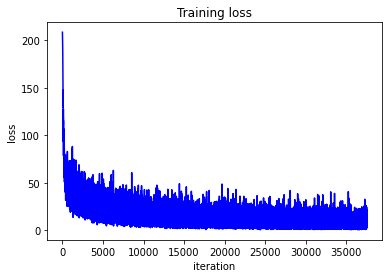

In [409]:
#Трэйнимся
mom_grads = []
first = True
history = []
for epoch in range(epochs):
    model.train()
    for x,y in loader(train_x, train_y_enc, batch_size):

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y)

        grad = criterion.backward(y_pred, y)
        model.backward(x, grad)

        Momentum(model.parameters(),
            model.grad_parameters(),
            learning_rate)

        #print(loss)
        history.append(loss)
        
    print(accur(model, loader(train_x, train_y, batch_size)), accur(model, loader(val_x, val_y, batch_size)))

plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()
#Слева train скор, справа - а валидации. Ура я смог дотянутся до скора 98.1%!!!!